### Evolution of Stellar Kinematics in M33

In this notebook, I am answering the question: how will the velocity dispersion of M33 evolve during the M31-MW merger?

I will plot the evolution of the velociy dispersion over time.

In [1]:
# import modules
import numpy as np
import astropy.units as u
from astropy.constants import G
import astropy.table as tbl

# import plotting modules
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
%matplotlib inline

# my modules
from Readfile import Read
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile

In [27]:
# make a class
class V_disp:
    # Class to compute the velocity and velocity dispersion of an input galaxy
    
    def __init__(self, galaxy, snap_id, ptype=2):
        
        """
        inputs: 
            galaxy: the name of the galaxy, input as string
            snap_id: the timestamp at which velocity is computed,
                     can be input as int or array of int
            ptype: the particle type whose velocity is computed
                    default: 2
                    1 for halo, 2 for stars, 3 for bulge
        """
        
            
        if snap_id < 9.9:
               self.filename = "/home/astr400b/VLowRes/%s" %(galaxy) + "_00" + str(snap_id) + ".txt"
        elif snap_id < 99.9:
               self.filename = "/home/astr400b/VLowRes/%s" %(galaxy) + "_0" + str(snap_id) + ".txt"
        elif snap_id > 99.9:
              self.filename = "/home/astr400b/VLowRes/%s" %(galaxy) + "_" + str(snap_id) + ".txt"
        # read data in the given file using Read
        self.time, self.total, self.data = Read(self.filename)                                                                                             

        #create an array to store indexes of particles of desired Ptype                                
        self.index = np.where(self.data['type'] == ptype)

        # store the mass, positions, velocities of only the particles of the given type
        # the following only gives the example of storing the mass
        self.m = self.data['m'][self.index]
        # write your own code to complete this for positions and velocities
        self.m = self.data["m"][self.index]
        self.x = self.data["x"][self.index]
        self.y = self.data["y"][self.index]
        self.z = self.data["z"][self.index]
        self.vx = self.data["vx"][self.index]
        self.vy = self.data["vy"][self.index]
        self.vz = self.data["vz"][self.index]
        
        
    def ReltoCoM(self):
        """
        function computes position and velocity of particles relative to their center of mass
        inputs: none, accepts inputs from __init__
        returns: 
            vtot: the total magnitude of the velocity vector
            vD: the 3-vector velocity
            rD: the 3-vector position
        """
        
        # Create instance of CenterOfMass of oobject
        COMD = CenterOfMass(self.filename,2)
        
        # Compute COM position and velocity using disk particles
        COMP = COMD.COM_P(0.1,4)
        COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])
        
       
        # Determine positions of particles relative to COM 
        xD = COMD.x - COMP[0] 
        yD = COMD.y - COMP[1]
        zD = COMD.z - COMP[2] 
        
        # 3-vector position 
        rD = np.array([xD, yD, zD])
        
        # total magnitude of the position vector
        rtot = np.sqrt(xD**2 + yD**2 + zD**2)
        #set maximal radius
        rmax = 10
        r_index = np.where(rtot <= rmax)
        
        xinr = xD[r_index]
        yinr = yD[r_index]
        zinr = zD[r_index]
        
        rinr = np.array([xinr, yinr, zinr])
        rtotinr = np.sqrt((xinr**2)+(yinr**2)+(zinr**2))
        
        # Determine velocities of particles relative to COM motion
        vxD = COMD.vx - COMV[0]
        vyD = COMD.vy - COMV[1]
        vzD = COMD.vz - COMV[2]
        vxinMax = vxD[r_index]
        vyinMax = vyD[r_index]
        vzinMax = vzD[r_index]
        # 3-vector velocity
        vD = np.array([vxD, vyD, vzD])
        vinMax = np.array([vxinMax, vyinMax, vzinMax])
        # total magnitude of velocity vector
        vtot = np.sqrt(vxD**2 + vyD**2 + vzD**2)
        vtotinMax = np.sqrt((vxinMax**2)+(vyinMax**2)+(vzinMax**2))
                            
        return vtot, vD, rD, vtotinMax, vinMax, rinr

                    
    def velocity_dispersion(self, velocity):
        """
        function computes the velocity dispersion of particles
        inputs: velocity: the velocities whose dispersion you are computing
        returns: the velocity dispersion, the average velocity, and the ratio of velocity to dispersion
        """
        # compute average velocity
        avg_v = np.sum(velocity)/(len(velocity))
        
        # create array of zeros
        v_disp = np.zeros_like(velocity)
        
        # compute (velocity dispersion)**2
        for i in range(len(velocity)):
            v_disp[i] = (velocity[i]-avg_v)**2
        v_disp = np.sqrt(np.sum(v_disp)/len(v_disp))
        
        v_ratio = np.divide(avg_v, v_disp)
        
        # return average velocity and velocity dispersion
        return avg_v, v_disp, v_ratio
    

In [3]:
# as per Dr. Besla's reccomendation, a rotation


# a function that will rotate the position and velocity vectors
# so that the disk angular momentum is aligned with z axis. 

def RotateFrame(posI,velI):
    # input:  3D array of positions and velocities
    # returns: 3D array of rotated positions and velocities such that j is in z direction
    
    # transpose the inputs
    posI = posI.T
    velI = velI.T
    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    # normalize the vector
    L_norm = L/np.sqrt(np.sum(L**2))


    # Set up rotation matrix to map L_norm to z unit vector (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T)
    vel = np.dot(R, velI.T).T
    
    return pos, vel


In [4]:
M33_VDispersion = V_disp("M33",0)
M33_vtot, M33_vD, M33_r, M33_vtotM, M33_vM, M33_rM  = M33_VDispersion.ReltoCoM()
# I need to find the dimensions of the velocity arrays
print(M33_vD.shape[1])

9300


In [5]:

# set up zeros arrays
snap_ids = np.arange(0,800,5)

# arrays for the distances and velocities relative to CoM
M33_vD = np.zeros((len(snap_ids),3, 9300))
M33_rD = np.zeros_like(M33_vD)
print(M33_rD.shape)

rM_t = np.full((len(snap_ids),3,9300),np.nan)
vM_t = np.full_like(rM_t,np.nan)


# arrays for the 3-D Dispersion, Average, and Ratio
M33_vDisp  = np.zeros((len(snap_ids),3))
M33_vAvg   = np.zeros_like(M33_vDisp)
M33_vRatio = np.zeros_like(M33_vDisp)
vDispM     = np.zeros_like(M33_vDisp)
vAvgM      = np.zeros_like(M33_vDisp)
vRatioM    = np.zeros_like(M33_vDisp)

# arrays for the total velocities
M33_vtot        = np.zeros((len(snap_ids), 9300))
M33_RotatedTotV = np.zeros_like(M33_vtot)

# arrays for the total Average, Dispersion, and ratio
M33_TotAvg    = np.zeros(len(snap_ids))
M33_TotDisp   = np.zeros_like(M33_TotAvg)
M33_TotRatio  = np.zeros_like(M33_TotAvg)
vTotAvgM = np.zeros_like(M33_TotAvg)
vTotDispM = np.zeros_like(M33_TotAvg)
vTotRatioM = np.zeros_like(M33_TotAvg)


(160, 3, 9300)


In [6]:
# compute mean velocity and velocity dispersion along a given axis:
for i in range(len(snap_ids)):
    n = snap_ids[i]
    # create instance of class
    M33_VDispersion = V_disp("M33",n)
    
    # having the maximal radius doesn't work because the number of particles changes each time
    M33_vtot[i,:], M33_vD[i,:,:], M33_rD[i,:,:], vTotM, vM, rM = M33_VDispersion.ReltoCoM()
    
    # rotate such that angular momentum is along z axis
    M33_rotatedP, M33_rotatedV = RotateFrame(M33_rD[i,:,:], M33_vD[i,:,:])
    RotPM, RotVM = RotateFrame(rM, vM)
    M33_rD[i,:,:] = M33_rotatedP
    M33_vD[i,:,:] = M33_rotatedV.T
    rM = RotPM
    vM = RotVM.T
    for k in range(len(rM[0,:])):
        vM_t[i,:,k] = vM[:,k]
        rM_t[i,:,k] = rM[:,k]
    
    # calculate total v
    M33_RotatedTotV[i,:] = np.sqrt((M33_rotatedV[:,0]**2 + M33_rotatedV[:,1]**2 + M33_rotatedV[:,2]**2))
    TotRotVM = np.sqrt(vM[0]**2 + vM[1]**2 + vM[2]**2)
    # compute total average velocity, v dispersion, and v/sigma
    M33_TotAvg[i], M33_TotDisp[i], M33_TotRatio[i] = M33_VDispersion.velocity_dispersion(M33_RotatedTotV[i])
    vTotAvgM[i], vTotDispM[i], vTotRatioM[i] = M33_VDispersion.velocity_dispersion(TotRotVM)
    
    # compute dimensional average, dispersion, v/sigma ratio
    for j in range(3):
        M33_vAvg[i,j], M33_vDisp[i,j], M33_vRatio[i,j] = M33_VDispersion.velocity_dispersion(M33_rotatedV[:,j])
        vAvgM[i,j], vDispM[i,j], vRatioM[i,j] = M33_VDispersion.velocity_dispersion(RotVM[:,j])

0 (8417,)
20 (8178,)
40 (7992,)
60 (7889,)
80 (7353,)
100 (7091,)
120 (6803,)
140 (32,)


In [7]:
# read in from Orbit_M33.txt from assignment 6 to get the time
M33t, M33x, M33y, M33z, M33vx, M33vy, M33vz = np.genfromtxt("Orbit_M33.txt",delimiter=" ", unpack = True)
t = M33t[0:len(snap_ids)]/10e2

# read in from Orbit_M31.txt from assignment 6 to get M31's position
M31t, M31x, M31y, M31z, M31vx, M31vy, M31vz = np.genfromtxt("Orbit_M31.txt",delimiter=" ", unpack = True)

# get positions of M33 relative to M31:
M33_M31x = np.subtract(M31x, M33x)
M33_M31y = np.subtract(M31y, M33y)
M33_M31z = np.subtract(M31z, M33z)
M33M31pos = np.zeros(160)
for i in range(160):
    M33M31pos[i] = np.sqrt((M33_M31x[i]**2) + (M33_M31y[i]**2) + (M33_M31z[i]**2))


# set fontsize
fs= 16


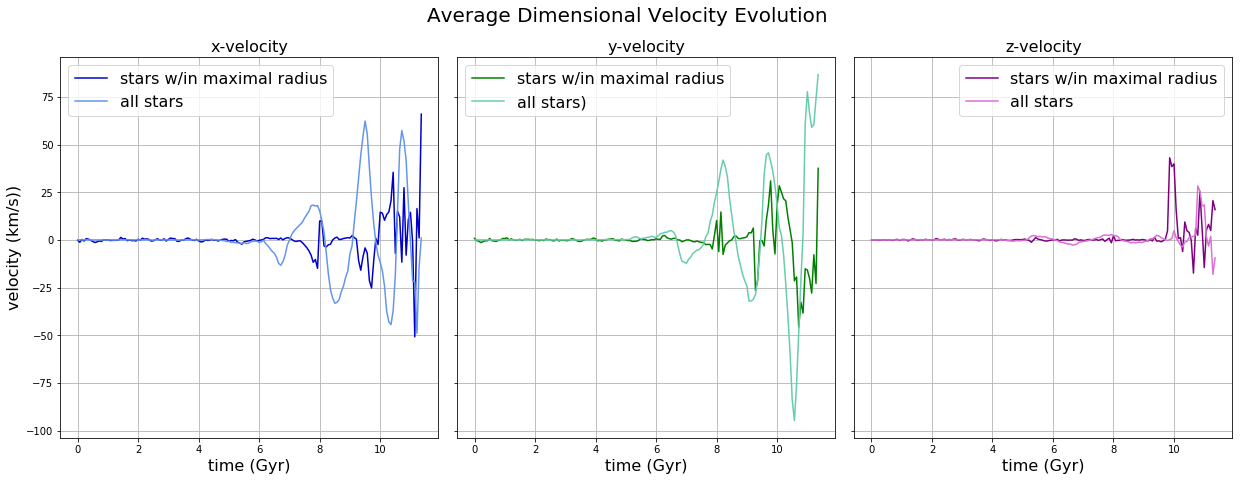

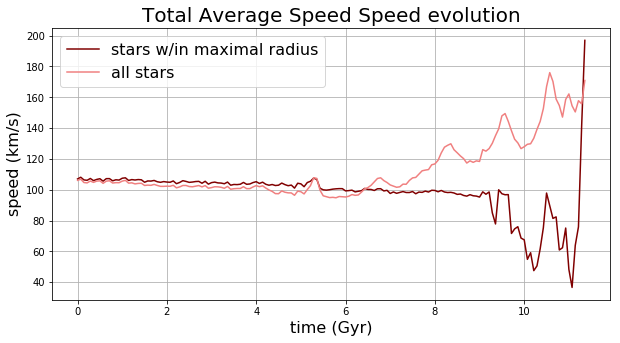

In [8]:
# plot the mean velocities over time
# create figure
fig, ax = plt.subplots(1,3,sharey=True,figsize=(21,7))
fig.suptitle("Average Dimensional Velocity Evolution",fontsize=20)
ax[0].set_title("x-velocity",fontsize=fs); ax[1].set_title("y-velocity",fontsize=fs); ax[2].set_title("z-velocity",fontsize=fs)
# get rid of the white space
plt.subplots_adjust(wspace=0.05)
ax[0].grid(True); ax[1].grid(True); ax[2].grid(True)
ax[0].set_xlabel("time (Gyr)",fontsize=fs); ax[1].set_xlabel("time (Gyr)", fontsize=fs); ax[2].set_xlabel("time (Gyr)",fontsize=fs)
ax[0].set_ylabel("velocity (km/s))",fontsize=fs)
# plot the dimensions
ax[0].plot(t, vAvgM[:,0],color="mediumblue",label="stars w/in maximal radius")
ax[0].plot(t, M33_vAvg[:,0], color="cornflowerblue",label="all stars")
ax[0].legend(fontsize=fs)
ax[1].plot(t, vAvgM[:,1],color="green", label="stars w/in maximal radius")
ax[1].plot(t, M33_vAvg[:,1], color="mediumaquamarine", label="all stars)")
ax[1].legend(fontsize=fs)
ax[2].plot(t, vAvgM[:,2],color="purple", label="stars w/in maximal radius")
ax[2].plot(t, M33_vAvg[:,2], color="orchid", label="all stars")
ax[2].legend(fontsize=fs)
plt.show()

#plot the total

plt.figure(figsize=(10,5))
plt.plot(t, vTotAvgM, color="maroon",label="stars w/in maximal radius")
plt.plot(t, M33_TotAvg,color="lightcoral", label="all stars")
plt.grid()
plt.title("Total Average Speed Speed evolution", fontsize=20)
plt.ylabel("speed (km/s)",fontsize=fs)
plt.xlabel("time (Gyr)",fontsize=fs)
plt.legend(fontsize=fs)
plt.show()
         

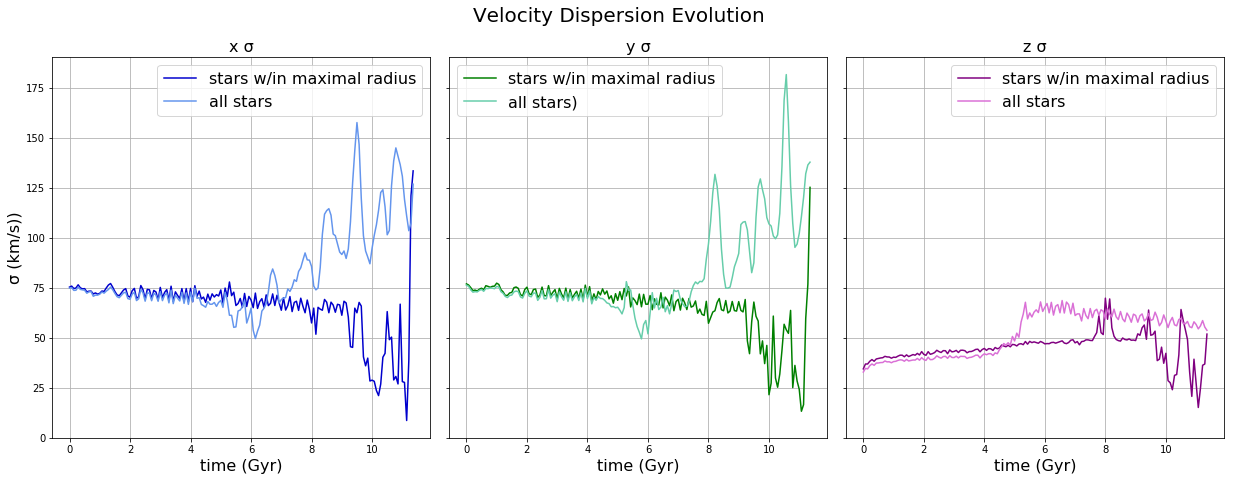

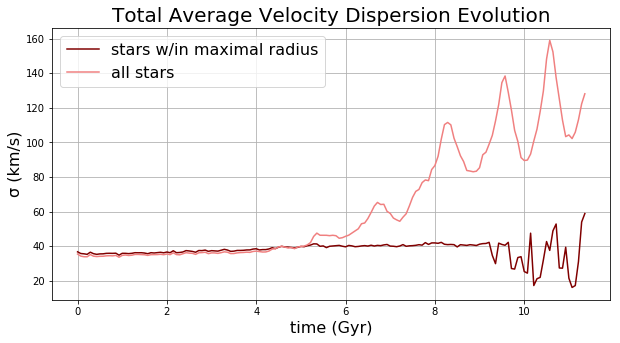

In [9]:
# plot the velocity dispersions
# create figure
fig, ax = plt.subplots(1,3,sharey=True,figsize=(21,7))
fig.suptitle("Velocity Dispersion Evolution",fontsize=20)
ax[0].set_title("x σ",fontsize=fs); ax[1].set_title("y σ",fontsize=fs); ax[2].set_title("z σ",fontsize=fs)
# get rid of the white space
plt.subplots_adjust(wspace=0.05)
ax[0].grid(True); ax[1].grid(True); ax[2].grid(True)
ax[0].set_xlabel("time (Gyr)",fontsize=fs); ax[1].set_xlabel("time (Gyr)", fontsize=fs); ax[2].set_xlabel("time (Gyr)",fontsize=fs)
ax[0].set_ylabel("σ (km/s))",fontsize=fs)
# plot the dimensions
ax[0].plot(t, vDispM[:,0],color="mediumblue",label="stars w/in maximal radius")
ax[0].plot(t, M33_vDisp[:,0], color="cornflowerblue",label="all stars")
ax[0].legend(fontsize=fs)
ax[1].plot(t, vDispM[:,1],color="green", label="stars w/in maximal radius")
ax[1].plot(t, M33_vDisp[:,1], color="mediumaquamarine", label="all stars)")
ax[1].legend(fontsize=fs)
ax[2].plot(t, vDispM[:,2],color="purple", label="stars w/in maximal radius")
ax[2].plot(t, M33_vDisp[:,2], color="orchid", label="all stars")
ax[2].legend(fontsize=fs)
plt.show()

#plot the total

plt.figure(figsize=(10,5))
plt.plot(t, vTotDispM, color="maroon",label="stars w/in maximal radius")
plt.plot(t, M33_TotDisp,color="lightcoral", label="all stars")
plt.grid()
plt.title("Total Average Velocity Dispersion Evolution", fontsize=20)
plt.ylabel("σ (km/s)",fontsize=fs)
plt.xlabel("time (Gyr)",fontsize=fs)
plt.legend(fontsize=fs)
plt.show()
         

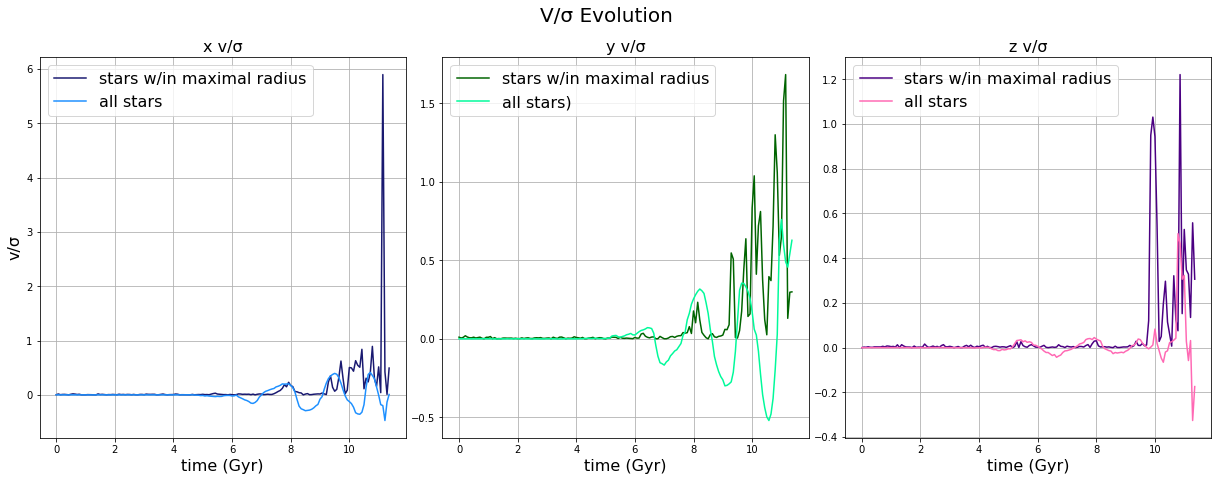

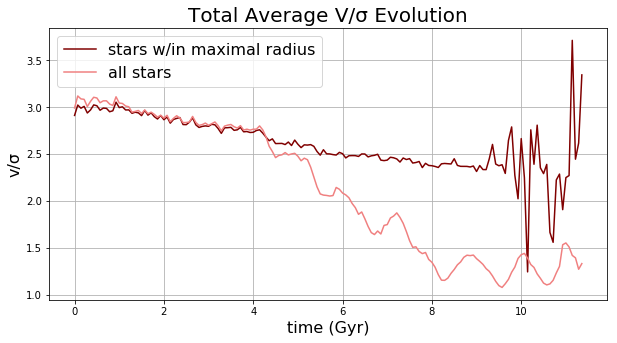

In [10]:
# plot the velocity dispersions
# create figure
fig, ax = plt.subplots(1,3,sharey=False,figsize=(21,7))
# get rid of the white space
plt.subplots_adjust(wspace=0.1)
# set all the titles
fig.suptitle("V/σ Evolution",fontsize=20)
ax[0].set_title("x v/σ",fontsize=fs); ax[1].set_title("y v/σ",fontsize=fs); ax[2].set_title("z v/σ",fontsize=fs)
# add axis labels
ax[0].set_xlabel("time (Gyr)",fontsize=fs); ax[1].set_xlabel("time (Gyr)", fontsize=fs); ax[2].set_xlabel("time (Gyr)",fontsize=fs)
ax[0].set_ylabel("v/σ",fontsize=fs)
# add grids
ax[0].grid(True); ax[1].grid(True); ax[2].grid(True)

# plot the dimensions
ax[0].plot(t, np.abs(vRatioM[:,0]),color="midnightblue",label="stars w/in maximal radius")
ax[0].plot(t, M33_vRatio[:,0], color="dodgerblue",label="all stars")
ax[0].legend(fontsize=fs)
ax[1].plot(t, np.abs(vRatioM[:,1]),color="darkgreen", label="stars w/in maximal radius")
ax[1].plot(t, M33_vRatio[:,1], color="mediumspringgreen", label="all stars)")
ax[1].legend(fontsize=fs)
ax[2].plot(t, np.abs(vRatioM[:,2]),color="indigo", label="stars w/in maximal radius")
ax[2].plot(t, M33_vRatio[:,2], color="hotpink", label="all stars")
ax[2].legend(fontsize=fs)
plt.show()

#plot the total

plt.figure(figsize=(10,5))
plt.plot(t, vTotRatioM, color="maroon",label="stars w/in maximal radius")
plt.plot(t, M33_TotRatio,color="lightcoral", label="all stars")
plt.grid()
plt.title("Total Average V/σ Evolution", fontsize=20)
plt.ylabel("v/σ",fontsize=fs)
plt.xlabel("time (Gyr)",fontsize=fs)
plt.legend(fontsize=fs)
plt.show()
         

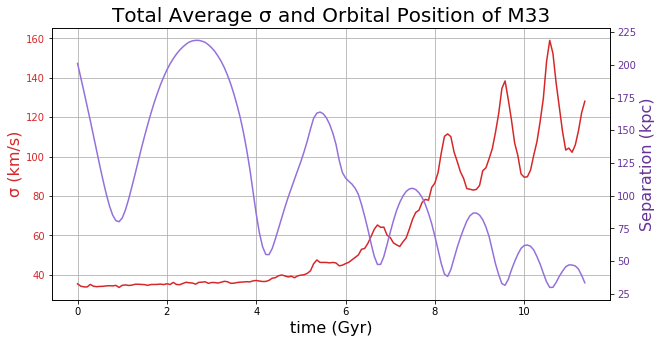

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
# set title
ax.set_title("Total Average σ and Orbital Position of M33",fontsize=20)
ax.set_xlabel("time (Gyr)",fontsize=fs)
ax.set_ylabel("σ (km/s)",fontsize=fs,color="tab:red")
ax.plot(t, M33_TotDisp,color="tab:red", label="σ (all stars)")
ax.tick_params(axis="y",labelcolor="tab:red")

ax2 = ax.twinx()
ax2.set_ylabel("Separation (kpc)",color="rebeccapurple", fontsize=fs)
ax2.plot(t, M33M31pos, color="mediumpurple",label="Relative Position of M33 to M31")
ax2.tick_params(axis="y",labelcolor="rebeccapurple")
ax.grid(True)

plt.show()

Assuming I did this correctly (which is assuming a lot), M33 becomes a kind of oblate spheroid elliptical

In [17]:
# make a phase diagram at certain times

# set the times we want
times = np.array([0, 2, 4, 6, 8, 10])
# make index of those particular times

snapNumbers = np.zeros((6))

# get the positions and velocities at those snap numbers

rSnapNumbers = np.zeros((6,3,9300))

vSnapNumbers = np.zeros_like(rSnapNumbers)
r_circ = np.arange(0.01, 10, 0.1)
v_circ = np.zeros((6,3,len(r_circ)))
rtot = np.zeros((6,9300))


for i in range(6):
    snapNumbers[i] = np.array(np.where(t==times[i]))
    new_info = V_disp("M33", np.int(snapNumbers[i]),2)
    vtot, vD, rD, vtotinMax, vinMax, rinr = new_info.ReltoCoM()
    Mass_Profile = MassProfile("M33",np.int(snapNumbers[i]))
    v_circ[i,:,:] = Mass_Profile.CircularVelocity(2,r_circ)
    


for i in range(6):
    snapNumbers[i] = np.array(np.where(t==times[i]))
    
    for k in range(3):

        rSnapNumbers[i,k,:] = M33_rD[np.int(snapNumbers[i]),k,:]
        vSnapNumbers[i,k,:] = M33_vD[np.int(snapNumbers[i]),k,:]
    
    Mass_Profile = MassProfile("M33",np.int(snapNumbers[i]))
    v_circ[i,:,:] = Mass_Profile.CircularVelocity(2,r_circ)
    rtot[i,:] = np.sqrt((rSnapNumbers[i,0,:]**2)+(rSnapNumbers[i,1,:]**2)+rSnapNumbers[i,2,:]**2)
    #print(rtot.shape)
    if i == 0: rindex1 = np.array(np.where(rtot[i,:]<=10))
    if i == 1: rindex2 = np.array(np.where(rtot[i,:]<=10))
    if i == 2: rindex3 = np.array(np.where(rtot[i,:]<=10))
    if i == 3: rindex4 = np.array(np.where(rtot[i,:]<=10))
    if i == 4: rindex5 = np.array(np.where(rtot[i,:]<=10))
    if i == 5: rindex6 = np.array(np.where(rtot[i,:]<=10))
        


In [18]:
print(rindex4[0])
goo = rindex4[0]
goo[0]

[   0    1    2 ... 9297 9298 9299]


0

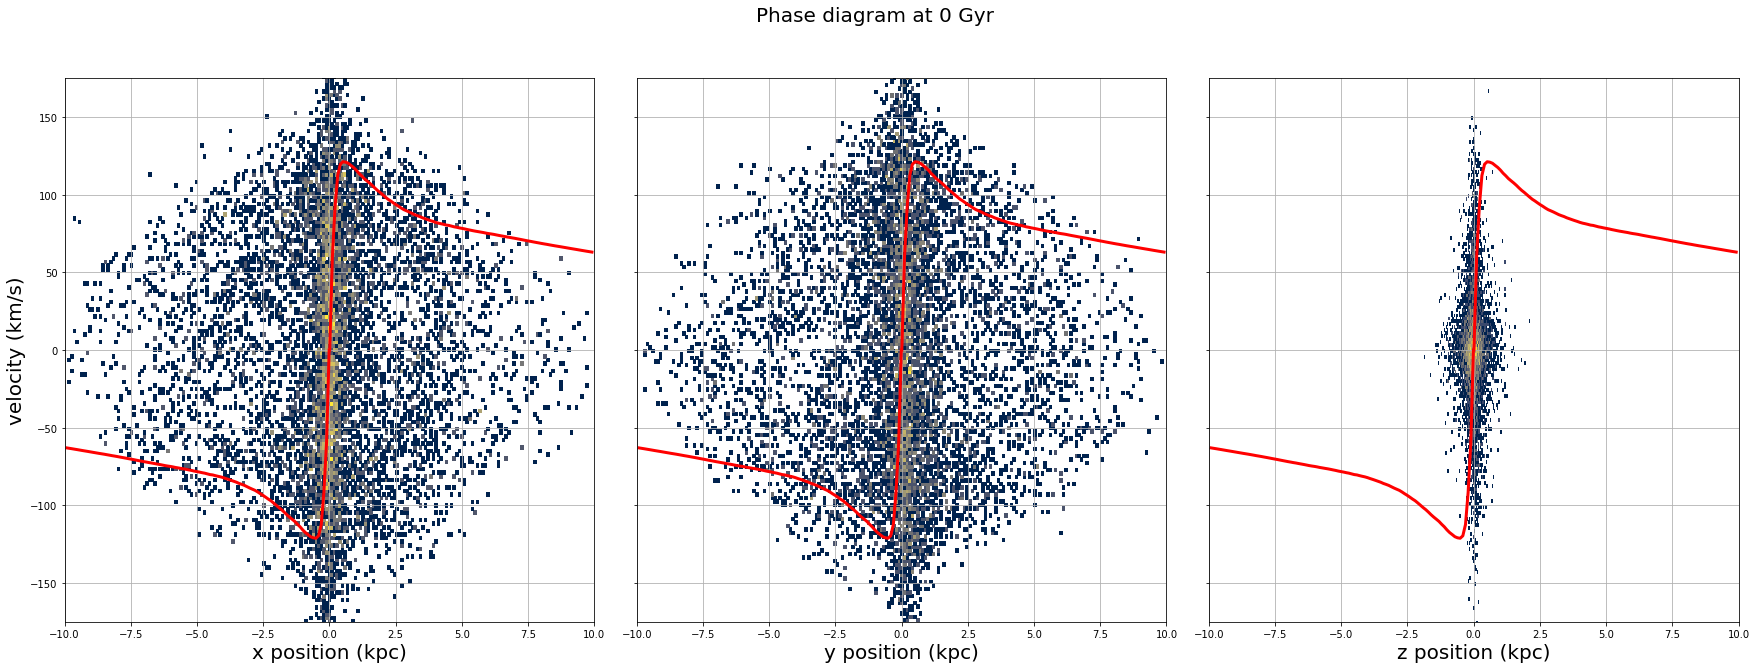

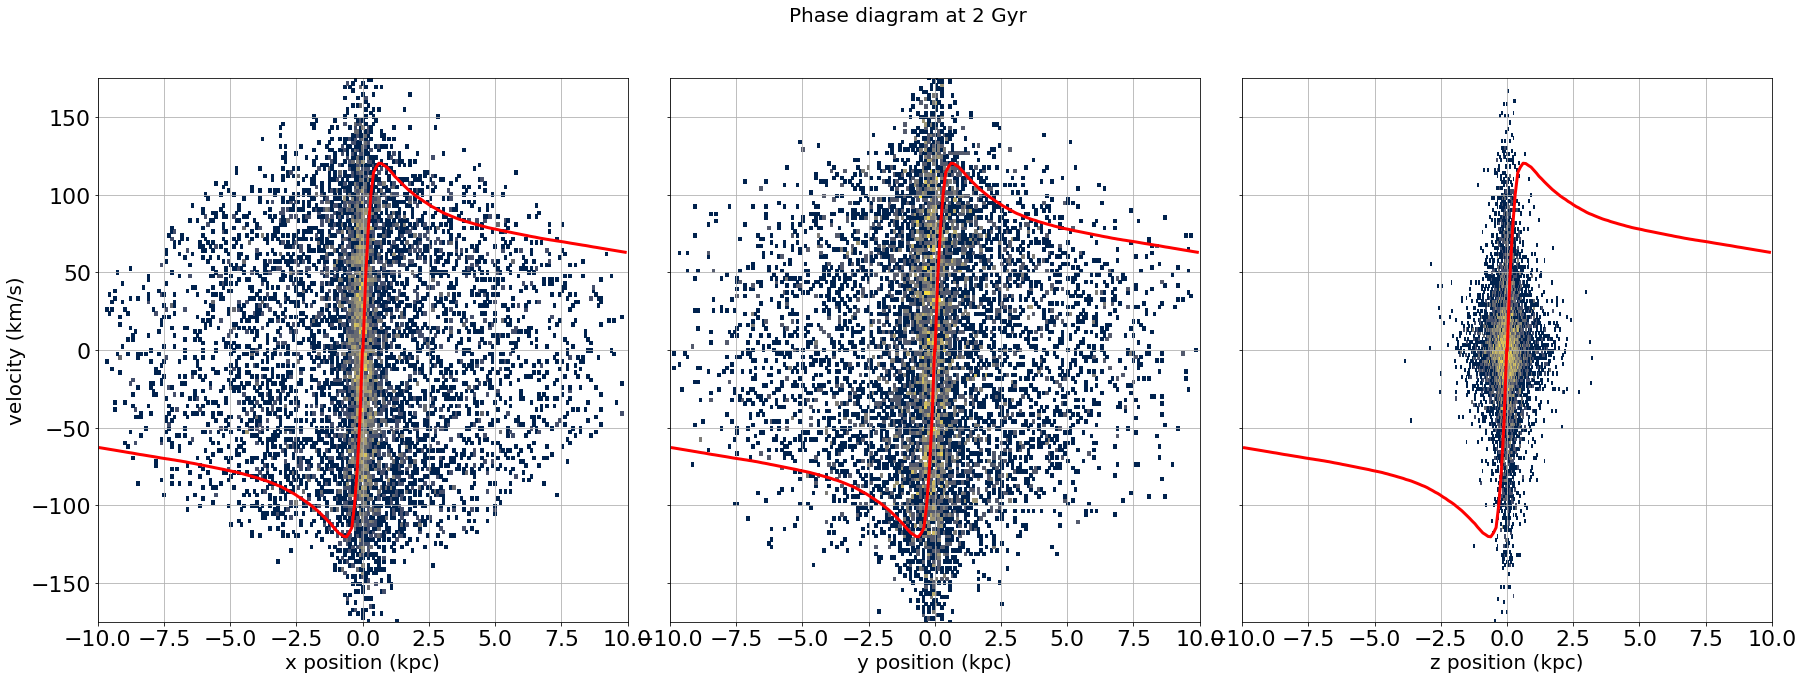

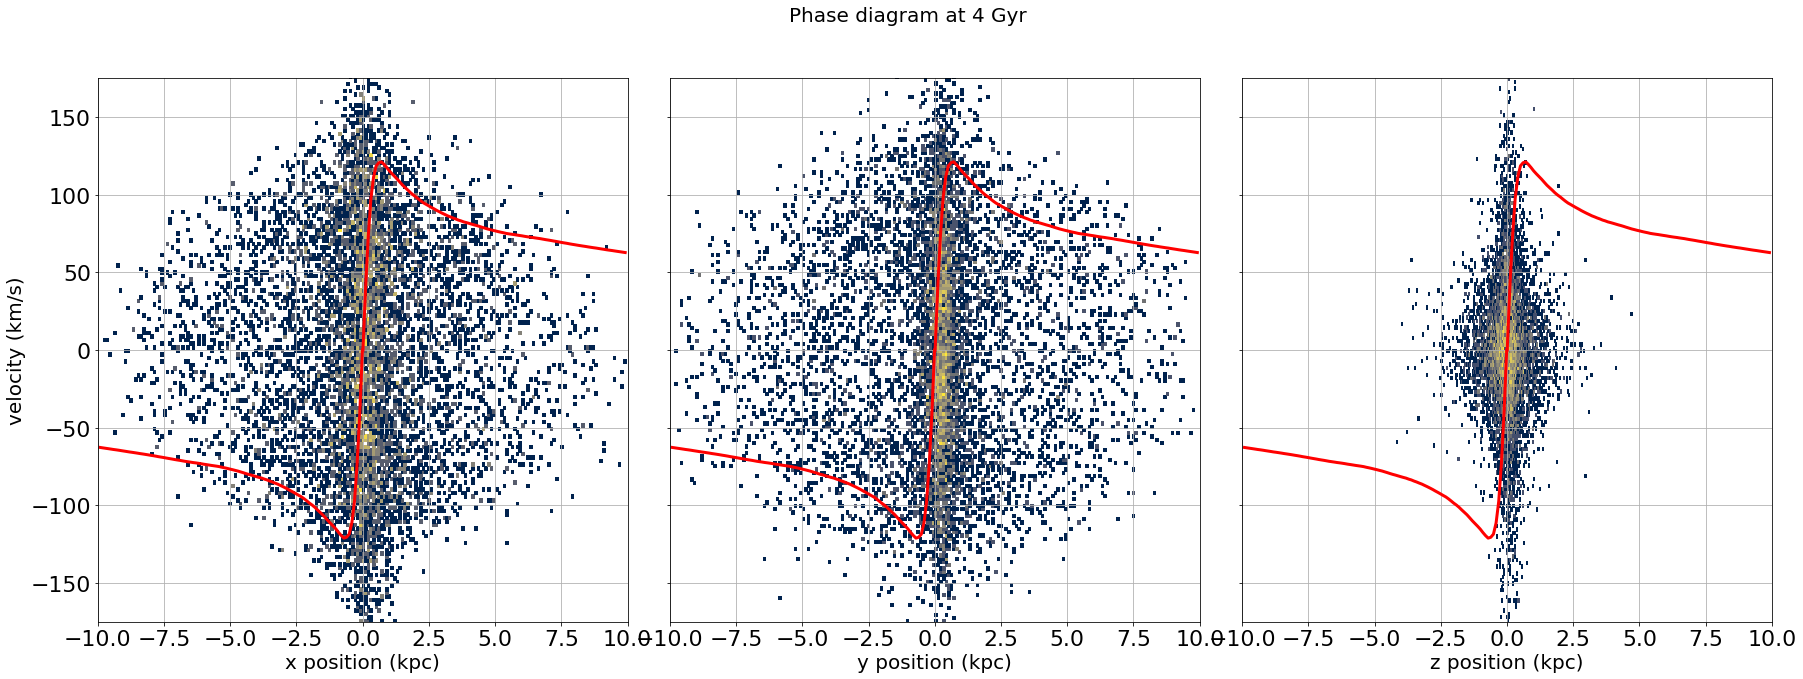

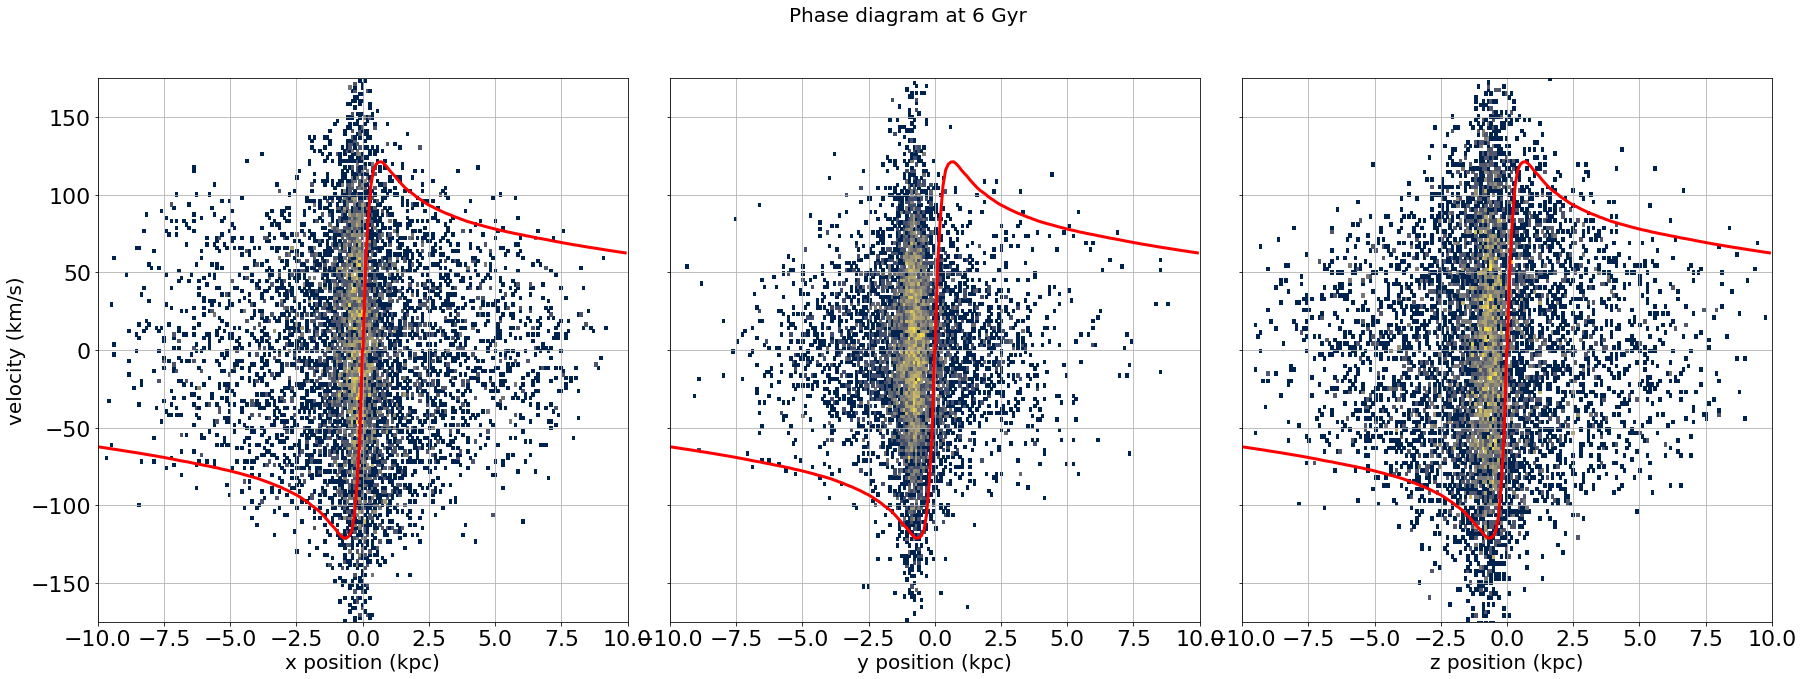

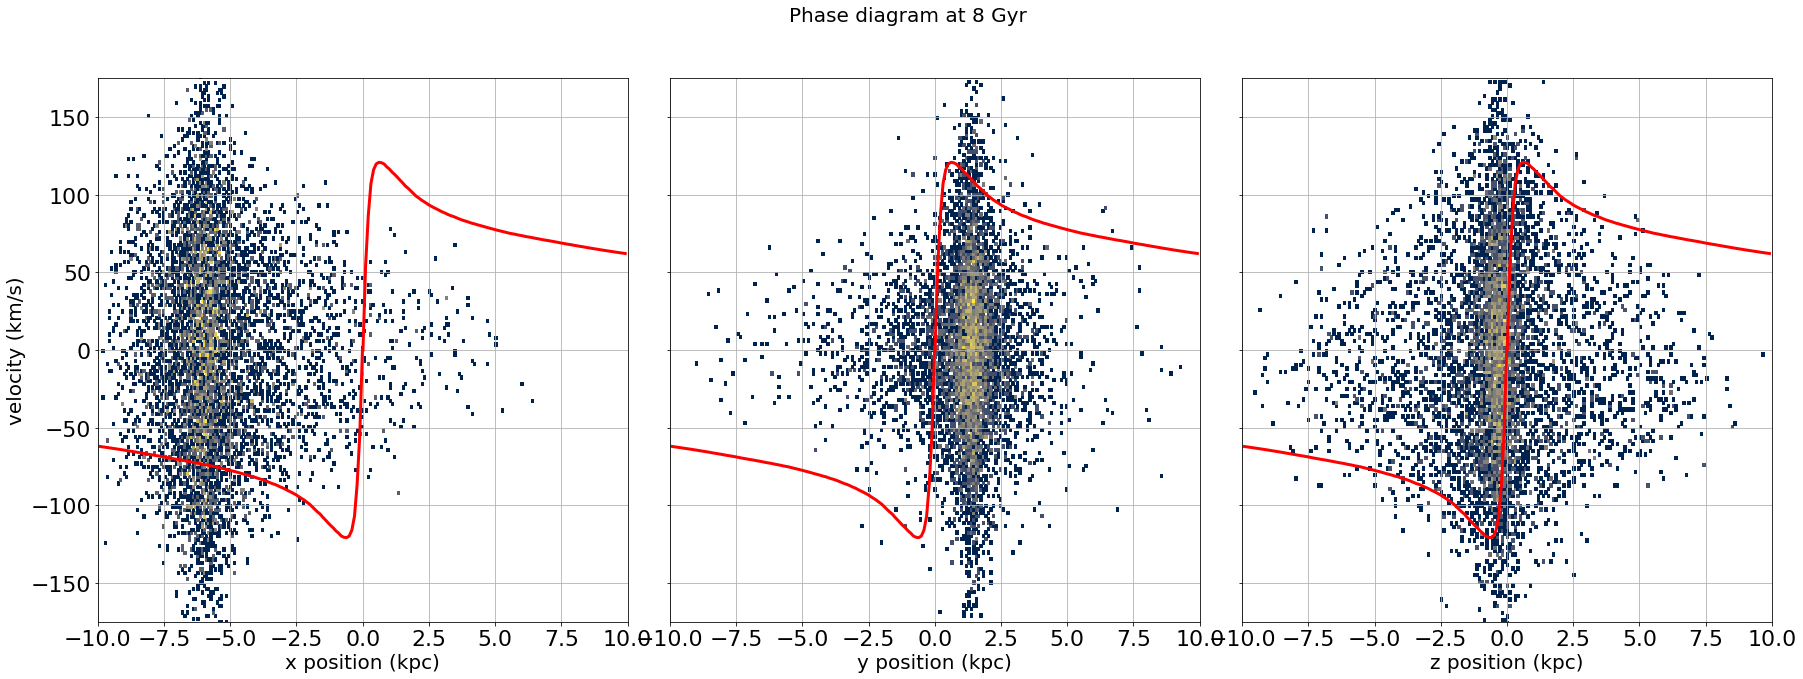

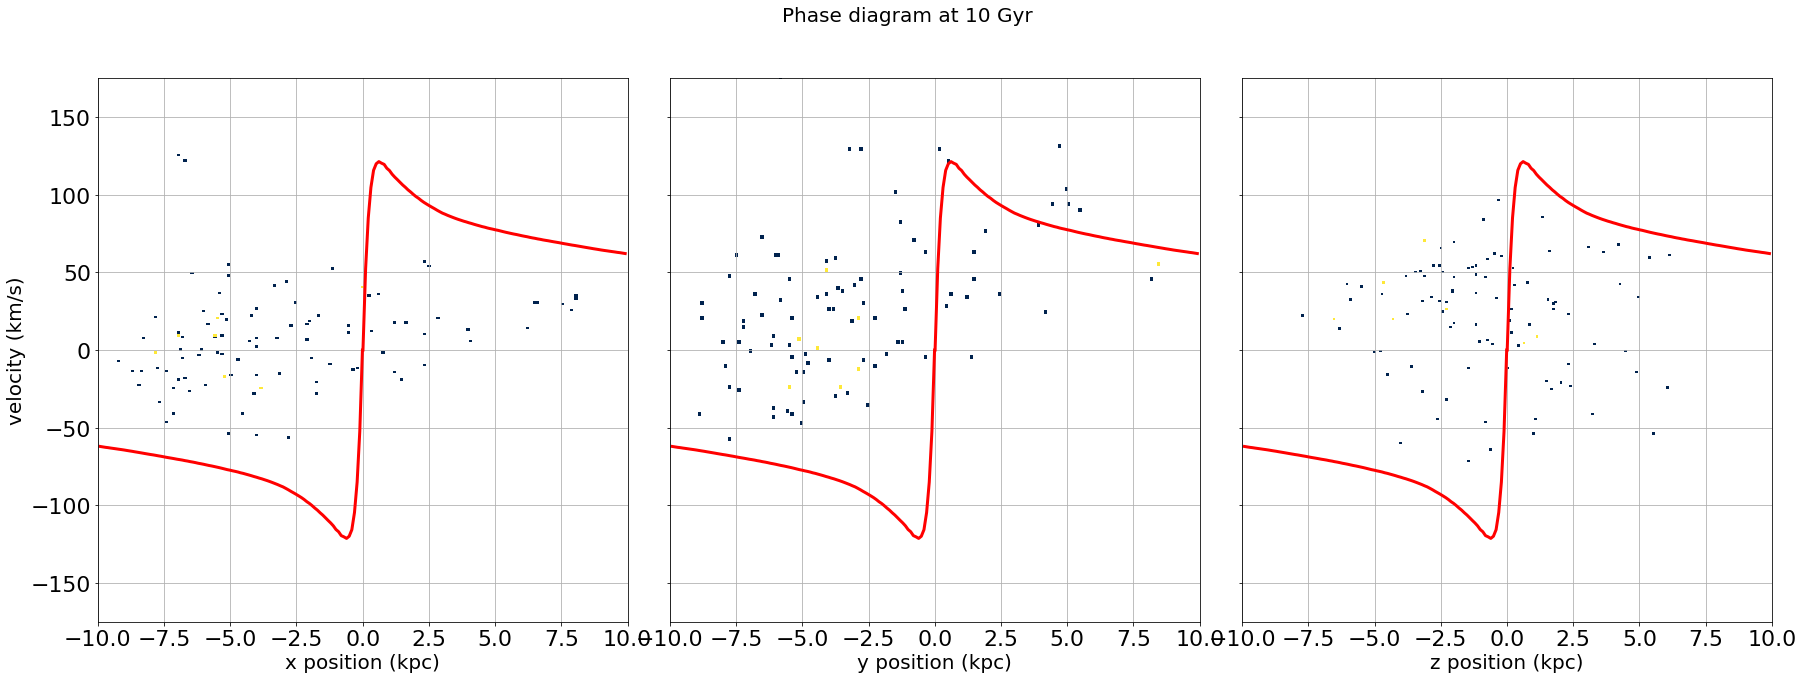

In [19]:
# plot the phase diagrams
xyz = ["x", "y", "z"]
r_circ = np.arange(0.01, 10, 0.1)
v_circ = np.zeros((6,3,len(r_circ)))

for i in range(6):
   
    fig, ax= plt.subplots(1,3,figsize=(30,10), sharey="row",gridspec_kw={'hspace':0,'wspace':.08})
    fig.suptitle("Phase diagram at %s Gyr"%times[i],fontsize=20)
    ax[0].set_ylabel("velocity (km/s)",fontsize=20)
    Mass_Profile = MassProfile("M33",np.int(snapNumbers[i]))
    v_circ = Mass_Profile.CircularVelocity(2,r_circ)

    for j in range(3):
        if i==0: index=rindex1[0] 
        if i==1: index=rindex2[0]
        if i==2: index=rindex3[0]
        if i==3: index=rindex4[0]
        if i==4: index=rindex5[0]
        if i==5: index=rindex6[0]
        x = rSnapNumbers[i,j,index]
        y = vSnapNumbers[i,j,index]
        #index = np.where(np.isnan(rSnapNumbers[i,j,:])==False)[0]
        ax[j].hist2d(x,y, bins=200, norm=LogNorm(),cmap="cividis")
        #ax[j].colorbar() # ask for help on doing the colorbar
        ax[j].plot(r_circ, v_circ, color="red",linewidth=3)
        ax[j].plot(-r_circ, -v_circ, color="red",linewidth=3)
        ax[j].grid()
        ax[j].set_ylim(-175,175)
        ax[j].set_xlim(-10,10)
        #ax[j].xlabe.l("y")
        for axs in ax.flat:
            ax[j].set_xlabel("%s position (kpc)"%xyz[j],fontsize=20)
    
            #axs.fontsize(19)
        label_size = 22
        matplotlib.rcParams['xtick.labelsize'] = label_size 
        matplotlib.rcParams['ytick.labelsize'] = label_size
    

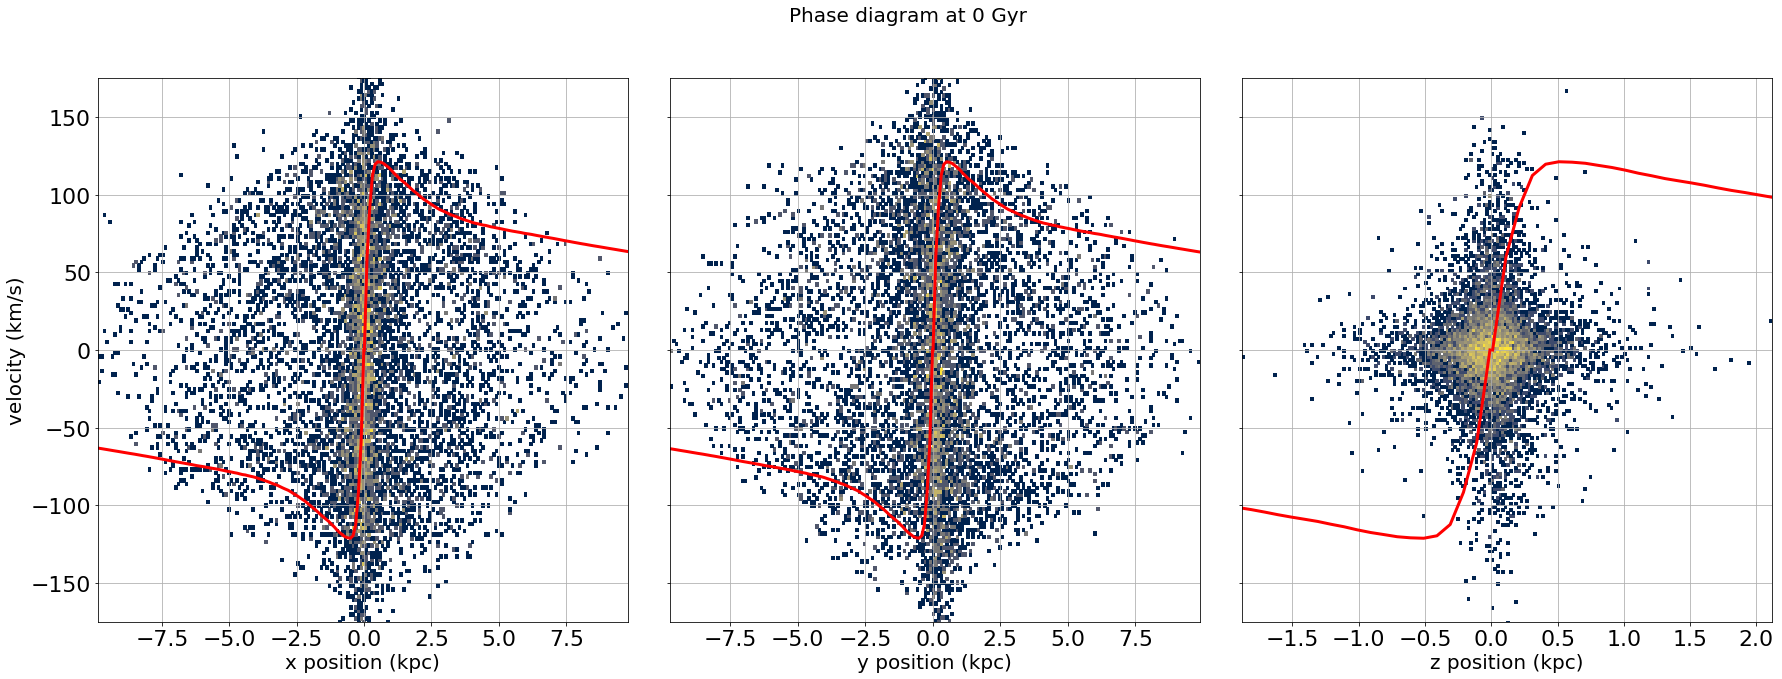

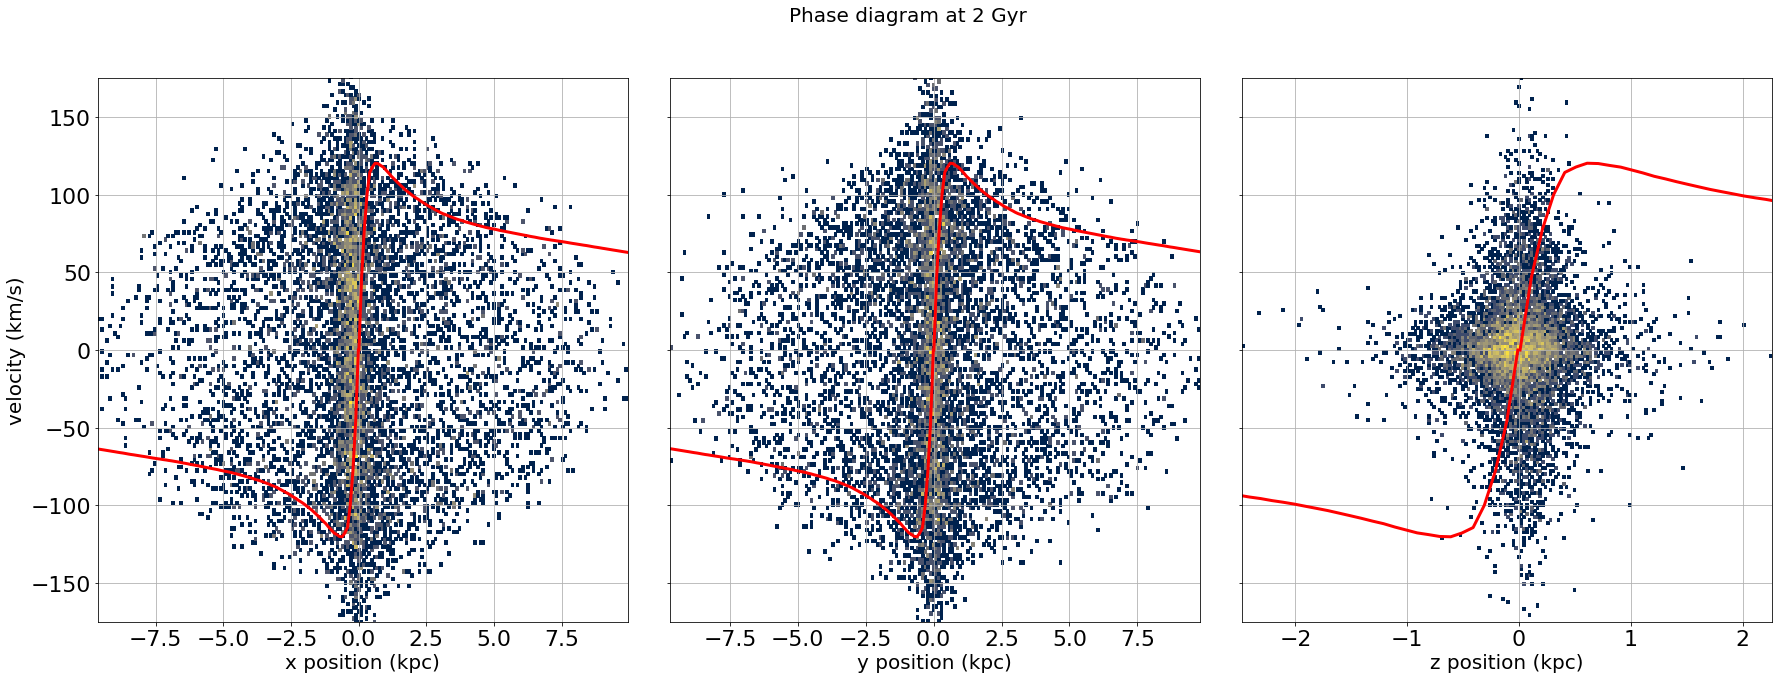

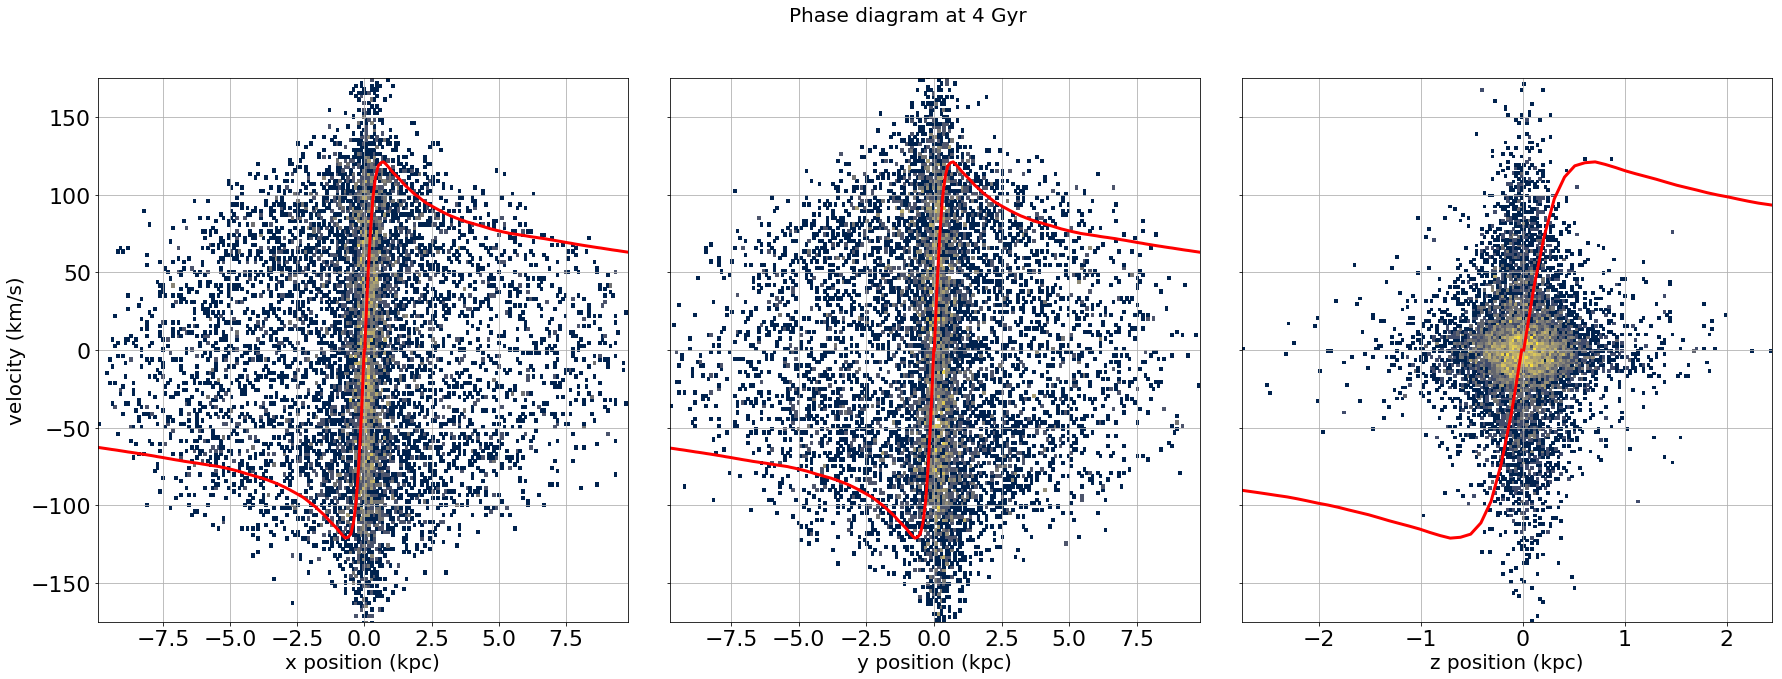

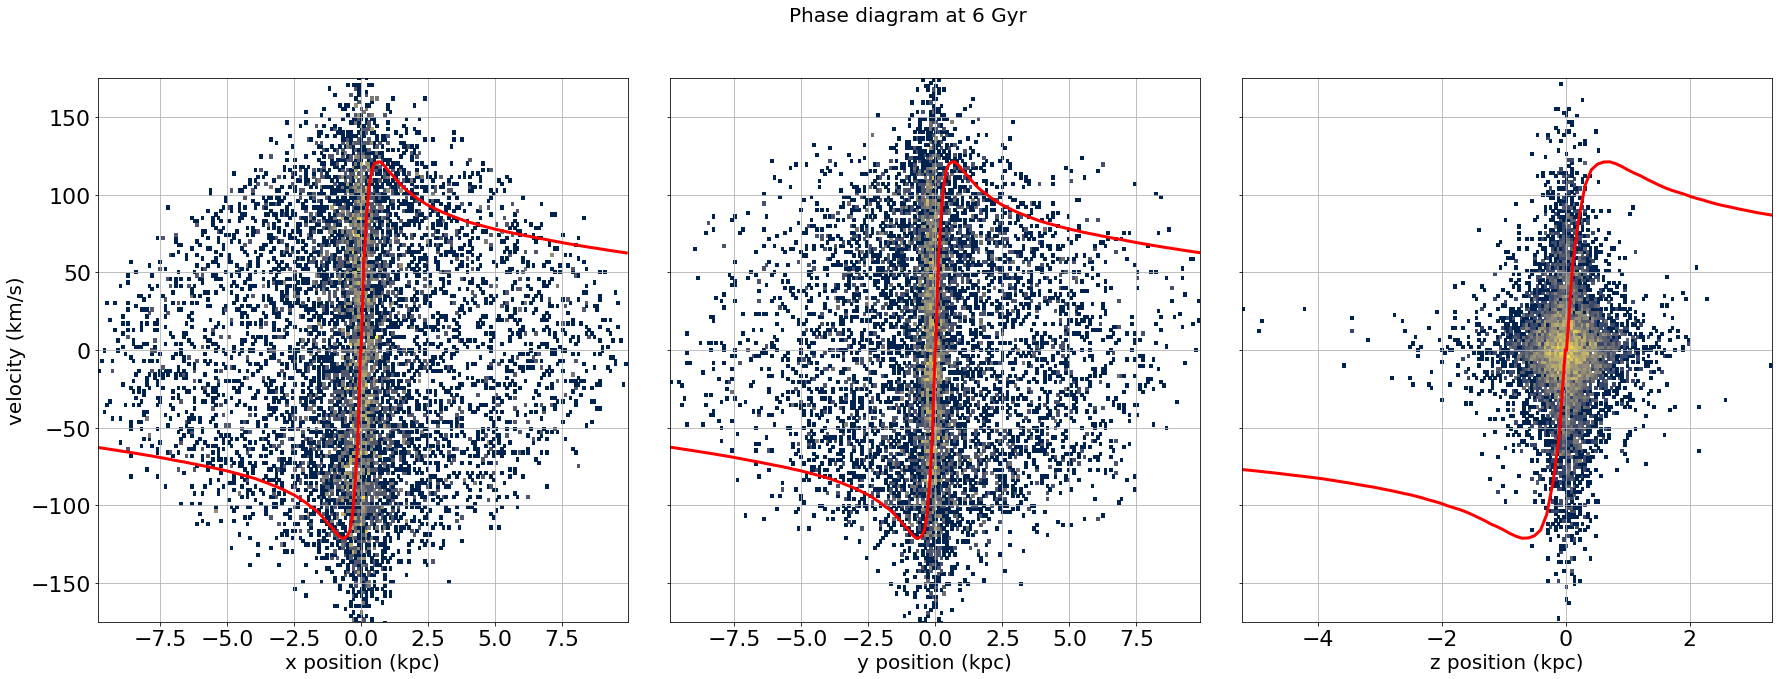

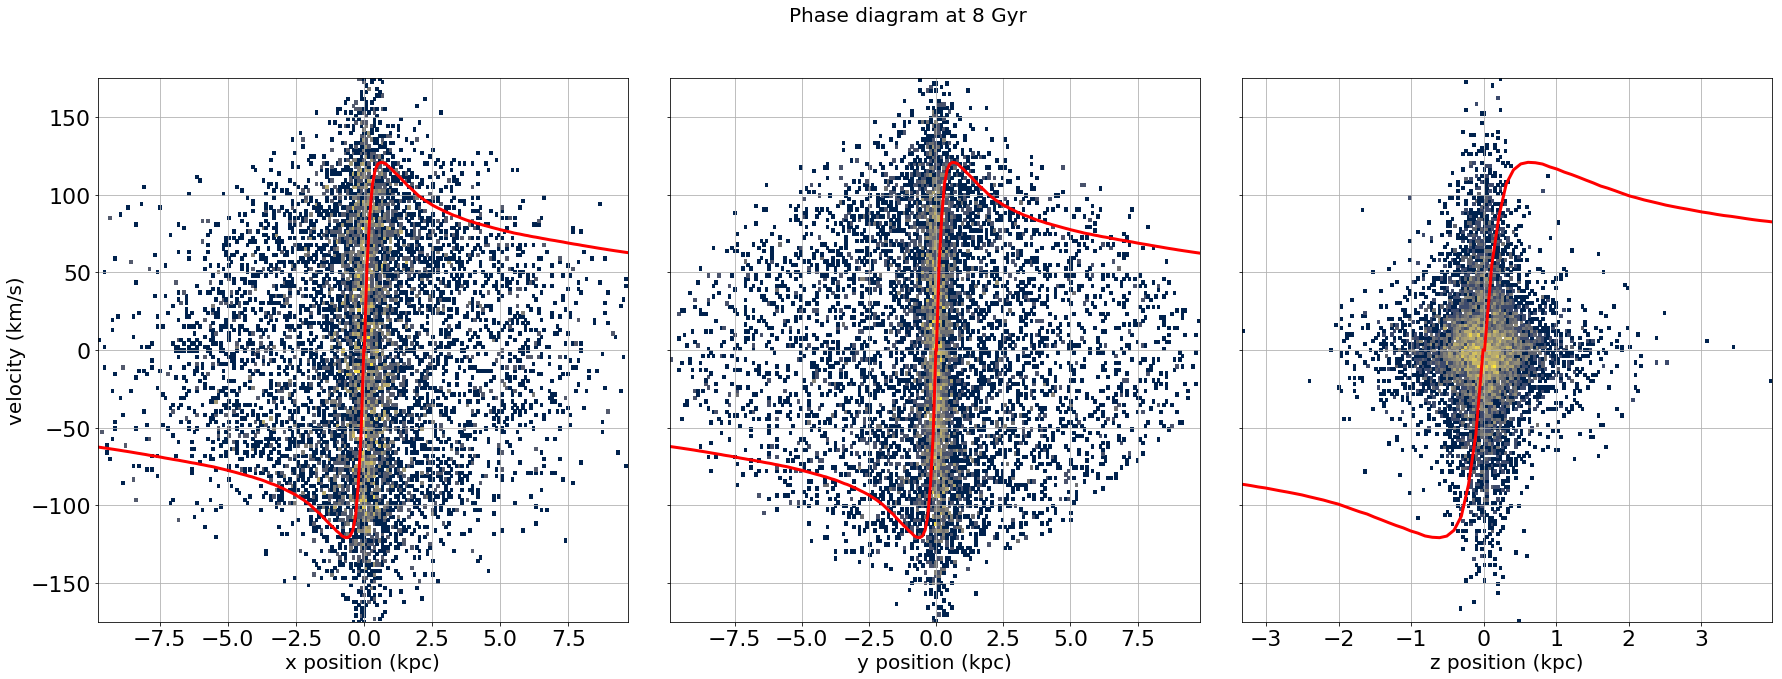

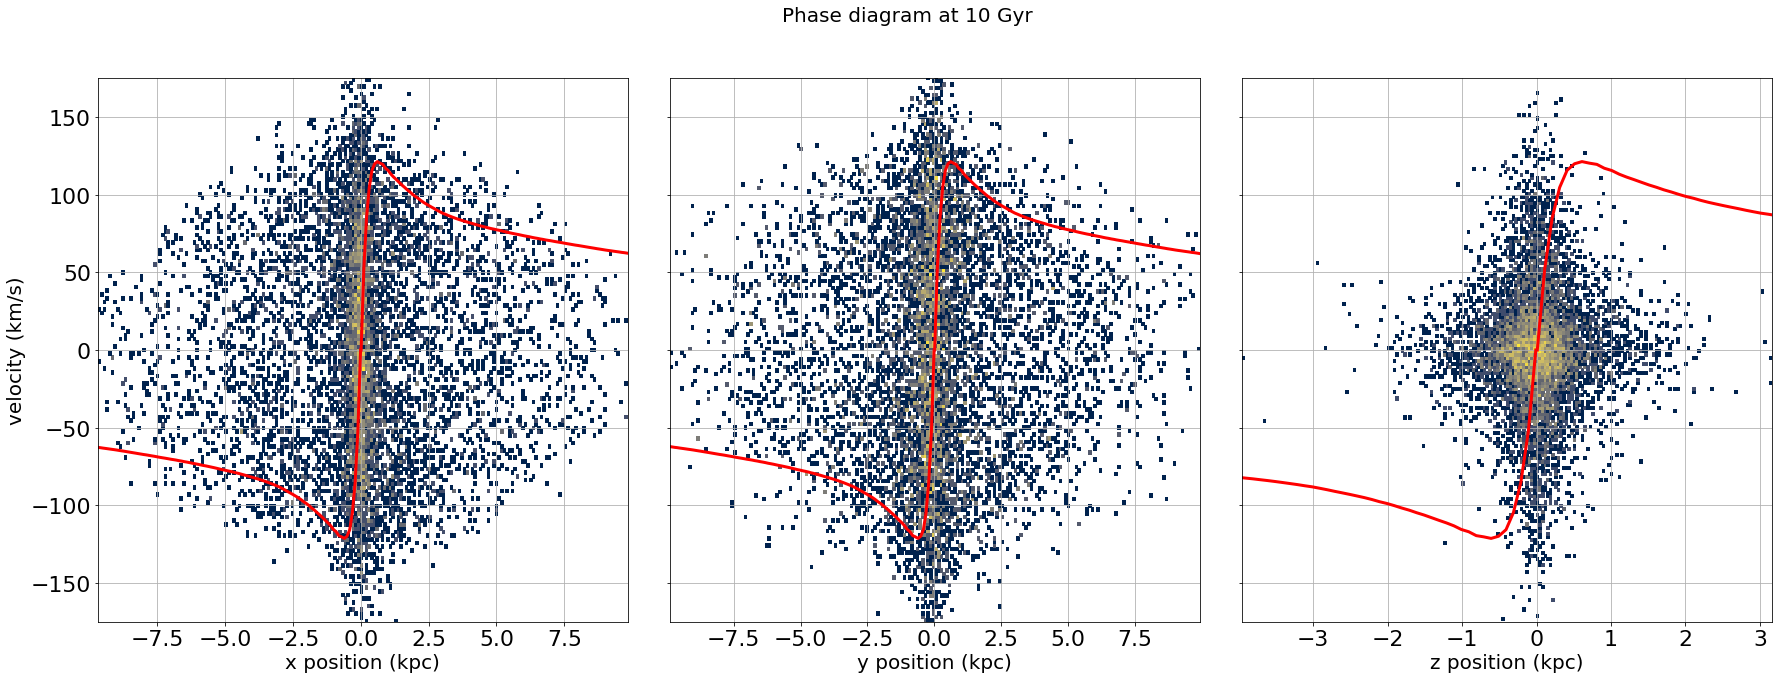

In [30]:
i = 0
r_circ = np.arange(0.01, 10, 0.1)
v_circ = np.zeros((6,3,len(r_circ)))
for i in range(6):
    snapNumbers[i] = np.array(np.where(t==times[i]))
    new_info = V_disp("M33", np.int(snapNumbers[i]),2)
    vtot, vD, rD, vtotinMax, vinMax, rinr = new_info.ReltoCoM()
    RotPM, RotVM = RotateFrame(rinr, vinMax)
    rM = RotPM
    vM = RotVM.T
    Mass_Profile = MassProfile("M33",np.int(snapNumbers[i]))
    v_circ[i,:,:] = Mass_Profile.CircularVelocity(2,r_circ)
    fig, ax= plt.subplots(1,3,figsize=(30,10), sharey="row",gridspec_kw={'hspace':0,'wspace':.08})
    fig.suptitle("Phase diagram at %s Gyr"%times[i],fontsize=20)
    ax[0].set_ylabel("velocity (km/s)",fontsize=20)
    for j in range(3):
        ax[j].hist2d(rM[j],vM[j], bins=200, norm=LogNorm(),cmap="cividis")
        #ax[j].colorbar() # ask for help on doing the colorbar
        ax[j].plot(r_circ, v_circ[i,j,:], color="red",linewidth=3)
        ax[j].plot(-r_circ, -v_circ[i,j,:], color="red",linewidth=3)
        ax[j].grid()
        ax[j].set_ylim(-175,175)
        #ax[j].set_xlim(-10,10)
        #ax[j].xlabe.l("y")
        for axs in ax.flat:
            ax[j].set_xlabel("%s position (kpc)"%xyz[j],fontsize=20)
    
            #axs.fontsize(19)
        label_size = 22
        matplotlib.rcParams['xtick.labelsize'] = label_size 
        matplotlib.rcParams['ytick.labelsize'] = label_size
    plt.savefig("Phase_%s"%snapNumbers[i]+".png")
    plt.show()